In [743]:
import numpy
import numpy as np
import time
import pyzx as zx
import ipyparallel as ipp
from scipy.stats import multinomial
from scipy import stats
from qiskit import Aer
import copy
import qiskit
from qiskit.quantum_info import Pauli
from qiskit.opflow import I,X,Y,Z
from qiskit.opflow.primitive_ops import PauliSumOp
from openfermion.linalg import givens_decomposition_square as givensRotns
from joblib import Parallel, delayed,Memory
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit.circuit.random import random_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister

$\hat{H}=\sum_{pq}t_{pq}c^{\dagger}_{p}c_{q}+\sum_{pqrs}h_{ps|qr}c^{\dagger}_{p}c^{\dagger}_{q}c_{r}c_{s}$<br>
Cholesky Decomposition through super matrix diagonalization-$h_{ps|qr}=\sum_{l=1}^{N^{2}}\mathcal{L}^{(l)}_{ps}\mathcal{L}^{(l)}_{qr}$,<br>
<br>
$\hat{H}=\sum_{pq}t_{pq}c^{\dagger}_{p}c_{q}+\sum_{l=1}^{N^{2}}\left(\sum_{p,s}c^{\dagger}_{p}\mathcal{L}^{(l)}_{ps}c_{s}\right)^{2}=\sum_{j,pq}\epsilon_{j}U^{(0)}_{pj}c^{\dagger}_{j}c_{j}U^{(0)*}_{qj}+\sum_{l=1}^{N^{2}}\left(\sum_{p,s}U_{pa}c^{\dagger}_{a}\mathcal{L}^{(l)}_{ps}c_{a}U^{\dagger}_{as}\right)^{2}$

In [956]:
#Construct Multiqubit gate
def add_multiqubit_gate(pauli_string, param, circuit):
    num_qubits=circuit.num_qubits
    qr=QuantumRegister(num_qubits,'q')
    if pauli_string == 'I'*num_qubits:
        gate = 1
        for j in range(len(pauli_string)):
            gate = numpy.kron(gate, Pauli('I').to_matrix())
        gate *= -1j * np.sin(param)
        gate += numpy.cos(param) * np.eye(2**num_qubits)
        circuit.unitary(gate, qr, label=pauli_string)
    else:
        qubits_to_act_on = []
        gate = 1
        for j in range(len(pauli_string)):
            if pauli_string[j] != 'I':
                gate=numpy.kron(Pauli(pauli_string[j]).to_matrix(),gate)
                qubits_to_act_on.append(num_qubits-j-1)
        gate *= (-1j * numpy.sin(param))
        gate += numpy.cos(param) * numpy.eye(2**len(qubits_to_act_on))
        List_regs=[qr[i] for i in qubits_to_act_on]
        Label=pauli_string+"\n{:0.02f}".format(param.real)
        circuit.unitary(gate, List_regs, label = Label)
    return circuit
#Construct Low rank factorized Hamiltonian
def LRF_Hamiltonian(num_qubits,h1=None,h2=None):
    def reshape_vec_to_mat(weightsAndcols_num_qubits):
        weight,vec,num_qubits=weightsAndcols_num_qubits
        L=numpy.sqrt(complex(weight))*numpy.reshape(vec,(num_qubits,num_qubits))
        return L
    #checksum  
    def higherRankRep(L):
        T=numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))*1j
        for p in range(num_qubits):
            for q in range(num_qubits):
                for r in range(num_qubits):
                    for s in range(num_qubits):
                        T[p,q,r,s]=L[p,q]*L[r,s]
        return T
    #build qubit rep of fermionic op
    def qubitOp(h1,h2):
        fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
        mapper=JordanWignerMapper()
        qubit_op=mapper.map(fer_op)
        return qubit_op
    #build basis change circuits for carrying out LRF and doubly decomposed Hamiltonian parts in new basis
    def LRF_circuits(h,num_qubits):
        qubitH=qubitOp(h,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
        H=qubitH.to_matrix()
        #qubitH2=qubitH.copy()
        w,v=numpy.linalg.eigh(h)
        givens=givensRotns(v.T)[0]
        W,V=numpy.linalg.eigh(H)
        M=V
        rotH=qubitH
        circ=QuantumCircuit(num_qubits)
        for rots in givens:
            for tup in rots:
                i,j,theta,phi=tup
                h1=numpy.zeros((num_qubits,num_qubits))*1j
                h1[i,j]=-1j
                h1[j,i]=1j
                qubit_h1=qubitOp(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
                List=qubit_h1.primitive.to_list()
                Op1=[('I'*num_qubits,numpy.cos(theta*List[0][1])),(List[0][0],1j*numpy.sin(theta*List[0][1]))]
                Op2=[('I'*num_qubits,numpy.cos(theta*List[1][1])),(List[1][0],1j*numpy.sin(theta*List[1][1]))]
                Op1=PauliSumOp.from_list(Op1)
                Op2=PauliSumOp.from_list(Op2)
                Op=Op2@Op1
                rotH=Op@rotH@Op.adjoint()
                rotH=rotH.reduce().reduce()
                Op_mat=(Op).to_matrix(massive=True) 
                circ=add_multiqubit_gate(List[0][0], theta*List[0][1], circ)
                circ=add_multiqubit_gate(List[1][0], theta*List[1][1], circ)
                M=Op_mat@M #unitary matrix implementation to demonstrate QR decompostion
        return circ,rotH,qubitH
    #constructing one electron and two electron tensors
    if numpy.all(h1)==None:
        h1=2*numpy.random.rand(num_qubits,num_qubits)-1
        #impose hermiticity on h1
        h1=(h1+h1.T)/2.
    if h2==None:
        h2=numpy.random.rand(num_qubits,num_qubits,num_qubits,num_qubits)
        #impose eight-fold symmetry
        h2=(1/8.)*(h2+numpy.transpose(h2,(3,2,1,0))+numpy.transpose(h2,(0,1,3,2))+numpy.transpose(h2,(1,0,2,3))
                  +numpy.transpose(h2,(1,0,3,2))+numpy.transpose(h2,(2,3,1,0))+numpy.transpose(h2,(2,3,0,1))
                  +numpy.transpose(h2,(3,2,0,1)))
    #qubit Hamiltonian    
    qubitH=qubitOp(h1,h2)    
    #constructing Low rank factorization circuits
    #Super matrix rep of four rank tensor (NxNxNxN)->(N^2xN^2)
    N2=num_qubits*num_qubits
    h2_ps_qr=numpy.reshape(h2,(N2,N2))
    #Diagonalize Super matrix
    w,v=numpy.linalg.eigh(h2_ps_qr)
    #Build Cholesky vectors
    Larr=[]
    arr=[(w[i],v[:,i],num_qubits) for i in range(len(v))]
    Larr=list(map(reshape_vec_to_mat,arr))
    h2_new=sum(list(map(higherRankRep,Larr)))
    print("checksum match-",numpy.allclose(h2,h2_new))
    #random clifford circuit for randomized benchmarking of DD form
    rand_circ=random_circuit(num_qubits,depth=7,measure=False)
    #Complete set circuits for basis change and rotated Operators in the new basis for 2-Body terms- DD form
    h2_rots_and_circs=[]
    for i in range(len(Larr)):
        coeff=-1j if w[i]<0 else 1
        circ,rotH,oldH=LRF_circuits(coeff*Larr[i],num_qubits)
        rotH2=(rotH@rotH).reduce().reduce()
        oldH2=(oldH@oldH).reduce().reduce()
        h2_rots_and_circs.append((circ,rotH2,oldH@oldH,rand_circ))
    #Basis change circuit and rotated Op in new basis for 1-Body terms
    basis_circ,rotH,oldH=LRF_circuits(h1,num_qubits)
    h1_rot_and_circ=[(basis_circ,rotH,oldH,rand_circ)]
    rotHs_and_circs=[h1_rot_and_circ,h2_rots_and_circs]
    def expectationH_statevector(Input):
        basis_change_circ,rotH,oldH,rand_circ=Input
        num_qubits=circ.num_qubits
        rand_circ1=copy.deepcopy(rand_circ)
        new_circ=rand_circ1+basis_change_circ
        state_vec=execute(new_circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
        H_expectation_part=(numpy.conjugate(state_vec)@rotH.to_matrix()@state_vec)
        return H_expectation_part.real
    state=execute(rand_circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    print(state.shape)
    H_expectation_From_DD=sum([expectationH_statevector(rotHs_and_circs[0][0])]+list(map(expectationH_statevector,rotHs_and_circs[1])))
    H_expectation_direct=numpy.conjugate(state)@oldH.to_matrix()@state
    print("Check",H_expectation_direct,H_expectation_From_DD)
    h2_rots_and_circs=[]
    for i in range(len(Larr)):
        coeff=-1j if w[i]<0 else 1
        circ,rotH,oldH=LRF_circuits(coeff*Larr[i],num_qubits)
        rotH2=(rotH@rotH).reduce().reduce()
        h2_rots_and_circs.append((circ,rotH2,oldH))
    h1_rot_and_circ=[LRF_circuits(h1,num_qubits)]
    rotHs_and_circs=[h1_rot_and_circ,h2_rots_and_circs]
    return rotHs_and_circs,h1,Larr

In [957]:
numpy.set_printoptions(precision=5,suppress=True)
num_qubits=4
H_LRF_circs,h1,Larr=LRF_Hamiltonian(num_qubits)

checksum match- True
(16,)
Check (8.447825069437424e-33+0j) 8.435092901937248e-17


In [960]:
circ,rotH_1body,oldH_1body=H_LRF_circs[1][0]

In [961]:
print("\x1b[1;31m rotated Hamiltonian- \x1b[0m ",'\n',rotH_1body,'\n',str(len(rotH_1body))+" terms",'\n\n'," \x1b[1;31m old Hamiltonian- \x1b[0m ",'\n',oldH_1body, '\n'+str(len(oldH_1body))+" terms")

 rotated Hamiltonian-   
 0.20683493298751005 * IIII
- 0.06097146463145649 * ZIII
- 0.00917892594636978 * IZII
+ 0.035044438374618035 * ZZII
+ 0.0038346661215588737 * IIZI
- 0.014640462442923793 * ZIZI
- 0.0022040428485110403 * IZZI
+ 0.0503459276881962 * IIIZ
- 0.19221690757618076 * ZIIZ
- 0.02893722122219948 * IZIZ
+ 0.012089059495758189 * IIZZ 
 11 terms 

   old Hamiltonian-   
 0.08935825862244393 * IIII
+ 0.0893437635529726 * ZIII
- 0.012639230554923733 * IZII
+ 0.13696923302399694 * IIZI
- 0.30303202464448975 * IIIZ
+ 0.0728149430052756 * XXII
+ 0.0728149430052756 * YYII
+ 0.10573690878311676 * XZXI
+ 0.10573690878311676 * YZYI
- 0.07328785549097996 * IXXI
- 0.07328785549097996 * IYYI
+ 0.003018365810708322 * XZZX
+ 0.003018365810708322 * YZZY
- 0.05125124412109072 * IXZX
- 0.05125124412109072 * IYZY
- 0.12478092275743716 * IIXX
- 0.12478092275743716 * IIYY 
17 terms


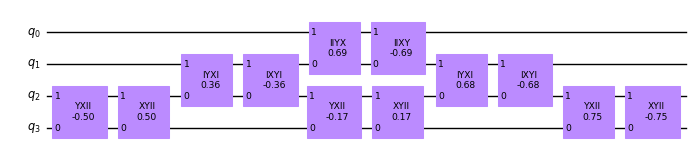

In [962]:
#Pre measurement basis rotation circuit Appending to ansatz
circ.draw('mpl',scale=0.7)

In [928]:
#Compiling circuit in terms of basis gates
new_circ=qiskit.transpile(circ,basis_gates=['rx','h','rz','cx'])

In [929]:
qasm_str_circ=new_circ.qasm()

In [930]:
import re

In [935]:
#re.sub( '.*$-pi,.*$', '.*$pi,.*$', qasm_str_circ)

In [933]:
with open('qasm_circ_test.qasm','w') as f:
    print(qasm_str_circ,file=f)

In [937]:
circuit = zx.Circuit.load("qasm_circ_test.qasm")
print(circuit.to_basic_gates().stats())

Circuit qasm_circ_test.qasm on 4 qubits with 143 gates.
        50 is the T-count
        93 Cliffords among which 
        24 2-qubit gates (24 CNOT, 0 other) and
        0 Hadamard gates.


In [938]:
g = circuit.to_graph()
display(zx.draw(g,scale=25))

None

In [939]:
zx.simplify.full_reduce(g,quiet=True)
print("Optim T-count:", zx.tcount(g))

Optim T-count: 30


In [940]:
new_circ = zx.extract_circuit(g)
optimized_circ = zx.optimize.basic_optimization(new_circ.to_basic_gates(),do_swaps=False)
print(optimized_circ.to_basic_gates().stats())

Circuit  on 4 qubits with 100 gates.
        30 is the T-count
        70 Cliffords among which 
        36 2-qubit gates (31 CNOT, 5 other) and
        26 Hadamard gates.


In [941]:
zx.draw(optimized_circ,scale=25)

In [942]:
optim_circ=QuantumCircuit.from_qasm_str(optimized_circ.to_qasm())
qiskit.transpile(optim_circ,basis_gates=['u1','u2','u3','cx'])

In [943]:
rand_circ=random_circuit(num_qubits=4,depth=10,measure=False)
rand_circ1=rand_circ.copy()
total_circ1=rand_circ1+optim_circ

In [944]:
state1=execute(total_circ1,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
state0=execute(rand_circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()

In [948]:
print(rotH_1body)

0.6509364131736168 * IIII
- 0.6599739181165746 * ZIII
- 0.49439066912267926 * IZII
- 0.024314348648140367 * IIZI
+ 0.5277425227137771 * IIIZ


In [949]:
(numpy.conjugate(state1.T)@rotH_1body.to_matrix()@state1).real

0.6502232622538832

In [950]:
numpy.conjugate(state0.T)@oldH_1body.to_matrix()@state0

0.6502232622538832